# Converting pyKasso network outputs to SWMM inputs #
**Authors:** Chloé Fandel 2022. <br>

Work session in Neuchâtel with Anthony & Philippe July 2022

### Setup & imports ###
For development, import a local version of pykasso be able to make and test changes.
Use one of the two methods below (but not both).


In [1]:
import sys
#sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
sys.path.append('C:/Users/cfandel/GitHub/pyKasso/pykasso') #path to local version of package
import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #uncomment this line to create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [2]:
#Import the rest of the modules needed:
import os            
import sys           
import importlib
import copy
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import karstnet as kn

#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann

In [3]:
#Local modules:
import_local_modules = True
if import_local_modules:
    import importlib.util
    #spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/Chloe/Documents/GitHub/gottesacker/swmmpy.py') #use local path on your own computer
    spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/cfandel/GitHub/pyKasso/pykasso/swmmpy.py')
    sp = importlib.util.module_from_spec(spec)  #swmmpy will be referred to as sp
    spec.loader.exec_module(sp)

os.getcwd()

'C:\\Users\\cfandel\\GitHub\\pyKasso\\notebooks'

## Simple one-valley system ###
A simple synthetic system, consisting of a single outlet draining a valley. There are only three geologic units: highly karstifiable limestone folded into a syncline along the valley axis, underlain by non-karstifiable shale, with an obstacle in the form of a non-karstifiable granite intrusion. Five inlets are randomly distributed across the upper part of the valley. 

CAUTION: You are using the development version of this package.
- initialize_costMap() - Warning : no geology n 0 found.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


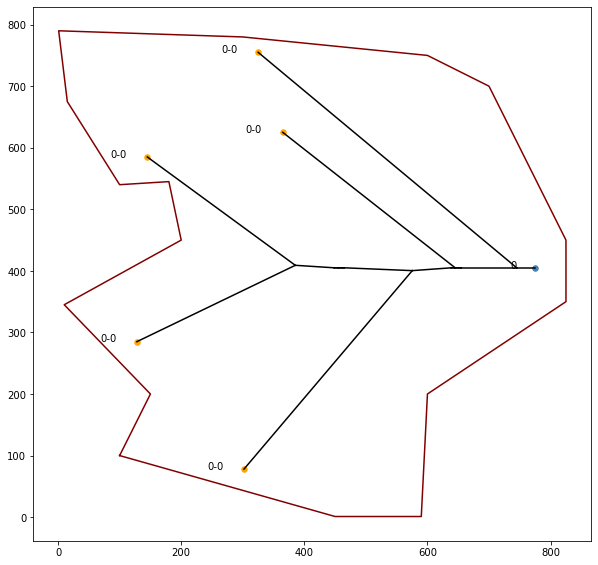

In [4]:
importlib.reload(pk)

#Load model:
catchment = pk.SKS('inputs/valley1/settings.yaml') 

#Modify model settings (uncomment to activate):
catchment.set_fractures_mode('null')                          #randomly generate a discrete fracture network
#catchment.set_outlets_data('inputs/valley1/outlets2D.txt')      #load a new outlet file with two outlets instead of one
#catchment.update_outlets()                                      #update
#catchment.set_outlets_importance([1,1])                         #assign one outlet to the first iteration and one to the second iteration
#catchment.set_inlets_per_outlet([2,3])                          #assign the first two inlets to the first outlet, and the remaining three inlets to the second outlet
#catchment.set_inlets_importance([1])                            #assign all inlets for each outlet to a single iteration
catchment.set_data_has_polygon(True)                             #add a polygon bounding the area of interest
catchment.update_polygon()

catchment.set_orientation_mode('surface')                        #use the lower surface of the karst unit as the anisotropy field
catchment.update_orientation()                                   #update

#Run anisotropic conduit network simulation & display results:
catchment.set_algorithm('Riemann2')
catchment.compute_karst_network()
#catchment.show()
catchment.show_network(data=catchment.karst_simulations[0], simplify=True, labels=['inlets','outlets'], plot_nodes=False, legend=False, color='k')


### Tsanfleuron system ###
Testing with Tsanfleuron data - below here, need to replace all Gottesacker files with Tsanfleuron files


#### Load example ####

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


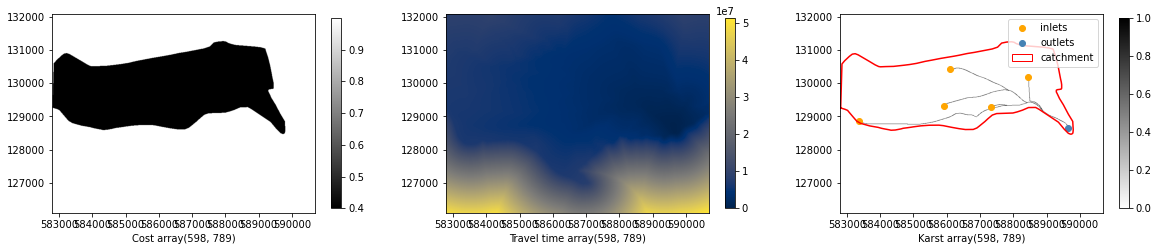

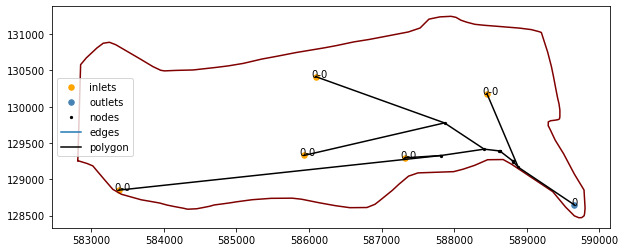

In [62]:
importlib.reload(pk)

catchment = pk.SKS('inputs/tsanfleuron/settings.yaml') #import settings and options from input folder

catchment.set_algorithm('Riemann2')
catchment.set_inlets_mode('composite')   #do a mix of preset and randomly-generated inlets
catchment.set_inlets_number(2)           #randomly generate 2 inlets
catchment.set_inlets_data('inputs/tsanfleuron/inlets2D_simple.txt') #load remaining inlets from file
catchment.update_all()
catchment.compute_karst_network()
catchment.show()
catchment.show_network(simplify=True)

The function below will eventually be integrated into pykasso as an export function.

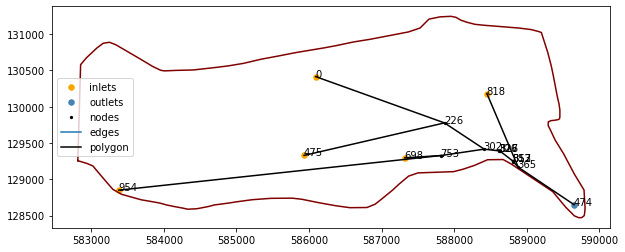

In [63]:
catchment.show_network(simplify=True, labels=['nodes'])

In [64]:
def pk2swmm(pkmodel, dim=2, simplify=True, renumber=False, elev_file=None):
    
    '''Converts network info (nodes and links) from pyKasso to pandas dataframes compatible with swmmpy. 
    
    Inputs:
    pkmodel:     pykasso model object
    elev_file:   text file with one column, for elevation of each node (only if using a 2D network with elevations added after)
    dim:         number of dimensions pykasso ran in (2 or 3) 
                 (if pykasso output a 2D network, must add Z coordinates to all nodes from elevation file)
    simplify:    True/False, whether to simplify the SKS network or not (defaults to True)
    renumber:    True/False, whether to renumber nodes and edges from zero
    
    Outputs:
    nodesSWMM:   pandas df with all nodes, and columns: X, Y, Z, type, Name. Type is either 'junction', or 'outfall'
    linksSWMM:   pandas df with all links, and columns: InNode, OutNode, Name
    '''
       
    #Get nodes and edges from pykasso karst simulations:
    nodes = pkmodel.karst_simulations[0].network['nodes']
    edges = pkmodel.karst_simulations[0].network['edges']

    #Simplify
    if simplify==True:
        nodes_simple = pkmodel.karst_simulations[0].network['karstnet'].graph_simpl.nodes  #get indices of only the nodes in the simplified graph
        nodes_simple = {key: nodes[key] for key in nodes_simple}   #make df of only the nodes in the simplified graph, for plotting
        edges_simple = pkmodel.karst_simulations[0].network['karstnet'].graph_simpl.edges  #get only the edges in the simplified graph
        edges_simple = {i: edge for i,edge in enumerate(edges_simple)}   #make df of only the edges in the simplified graph, for p
        nodes = nodes_simple  #replace complex nodes object with simple nodes object
        edges = edges_simple  #replace complext edges object with simple edges object
        print('network simplified')
        
    #Convert to dataframe
    if dim == 2: 
        nodes = pd.DataFrame.from_dict(nodes, orient='index', columns=['X','Y','type']) #convert to pandas for easier plotting
        nodes.insert(2, 'Z', pd.read_csv(elev_file, header=None, names=['Z'])) #insert a column for Z value based on file
    if dim == 3:        
        nodes = pd.DataFrame.from_dict(nodes, orient='index', columns=['X','Y','Z','type']) #convert to pandas for easier plotting

    nodes['Name'] = nodes.index   #add a column at end for node name based on index
    edges = pd.DataFrame.from_dict(edges, orient='index', columns=['In','Out'])
    
    #Replace InNode and OutNode names with re-indexed node names from simplified network:
    if renumber:
        nodes.reset_index(drop=True, inplace=True) #reset index to start counting from zero
        
        ins, outs = [],[]                                                #create empty lists to store info
        for i in range(len(edges)):                                      #loop over each link index
            edge = edges.iloc[i]                                         #get current link
            ins.append(nodes.loc[nodes.Name==edge.In].index.values[0])       #get & store new simplified InNode index
            outs.append(nodes.loc[nodes.Name==edge.Out].index.values[0])     #same for OutNode
        edges['InNode'] = ins                                            #add column with simplified InNode indices
        edges['OutNode'] = outs                                          #add column with simplified OutNode indices
        edges.drop(columns=['In','Out'], inplace=True)    #drop unneeded columns with original complex node indices
        print('nodes renumbered')
              
    edges.rename(columns={'In':'InNode','Out':'OutNode'}, inplace=True) #rename columns
    edges['Name'] = edges.index.values                #add name column with 0-based indices
    nodes['Name'] = nodes.index.values                #add name column with 0-based indices
       
    return nodes, edges                               #return node and edge dataframes formatted for insertion into SWMM input file using swmmpy


In [65]:
#Create formatted node and link dataframes
nodes, links = pk2swmm(catchment, dim=2, simplify=True, renumber=False, elev_file='inputs/tsanfleuron/nodesZ_2.txt')

network simplified


In [66]:
links

,InNode,OutNode,Name
0,0,226,0
1,226,302,1
2,226,475,2
3,302,326,3
4,302,753,4
5,326,327,5
6,326,816,6
7,753,698,7
8,753,954,8
9,327,816,9


In [67]:
nodes

,X,Y,Z,type,Name
0,130413.540471,586091.303617,2400,inlet,0
226,129775.982081,587865.706129,2300,junction,226
302,129414.316303,588412.815842,2300,junction,302
475,129328.124069,585931.495372,2400,inlet,475
326,129390.012462,588622.822301,1500,junction,326
753,129325.919340,587811.402309,2300,junction,753
327,129384.502447,588634.210448,2300,junction,327
816,129385.984545,588630.735510,2300,junction,816
352,129253.986831,588803.312647,2300,junction,352
353,129244.090621,588811.713984,2300,junction,353


### To Do ###
Make simplified network correctly oriented so that links always point towards the spring.
Ideas for how to do this:
- Complex network is already correctly oriented
- Simple network has some links that go in opposite direction of what is desired
- First, look for all inlet nodes and make sure they are the "from" node (flip if not)
- Next, look for all outlet nodes and make sure they are the "to" node (flip if not)
- Next, look at each remaining intermediate node one at a time:
    - Follow complex network down until either:
        - Hit node that matches "to" node from simple graph -> this connection is OK, so leave it as is
        - Hit intersection (node with order > 2) that does NOT match node from simple graph -> this connection is flipped, so reverse the "to" and "from" nodes

In [68]:
edges_complex = catchment.karst_simulations[0].network['edges'] #get complex network from pykasso
edges_complex = pd.DataFrame.from_dict(edges_complex, orient='index', columns=['InNode','OutNode']) #convert to pandas df

for name in links.Name:                                         #loop over links in simple network
    print('\nlink:',name, 'InNode:',links.loc[name].InNode,'OutNode:',links.loc[name].OutNode)
    
    #Deal with flipped links at inlets:
    if nodes.loc[links.loc[name].OutNode].type=='inlet':  #if this link has an inlet downstream, flip it
        InNode = links.loc[name].InNode
        OutNode = links.loc[name].OutNode
        links.at[name,'InNode'] = OutNode
        links.at[name,'OutNode'] = InNode
        print('flipped link',name,'because: downgradient inlet')
    
    #Deal with flipped links at outfalls:
    if nodes.loc[links.loc[name].InNode].type=='outfall': #if this link has an outfall upstream, flip it
        InNode = links.loc[name].InNode
        OutNode = links.loc[name].OutNode
        links.at[name,'InNode'] = OutNode
        links.at[name,'OutNode'] = InNode
        print('flipped link',name,'because: upgradient outfall')
    
    #Deal with flipped links in between:
    InNodeSimple = links.loc[name].InNode        #get the name of the upstream node in the simple network
    OutNodeSimple = links.loc[name].OutNode      #get the name of the downstream node in the simple network
    OutNodeComplex = edges_complex[edges_complex.InNode==InNodeSimple].OutNode.values[0] #get the name of the downstream node in the complex network
    stopNodes = nodes[nodes.type!='junction'].Name.values   #make a list of all inlet and outlet nodes - if these nodes are reached, loop will stop
    stopNodes = np.append(stopNodes,OutNodeSimple)          #append the downstream node of the current link in the simplified network - if this node is reached, loop will stop
    print('Starting to walk down graph')
    print('Initial in node (simple):', InNodeSimple)
    print('Initial out node (simple):', OutNodeSimple, '(complex):', OutNodeComplex)
    print('Stop Nodes:', stopNodes)
    while OutNodeComplex not in stopNodes:     #while the out node of the complex network isn't in the list of nodes that trigger a stop
        InNodeComplex = OutNodeComplex         #update the in node to be the previous complex out node
        OutNodeComplex = edges_complex[edges_complex.InNode==InNodeComplex].OutNode.values[0]  #update the out node to be the downstream node of the link starting from the new in node
        #print('New out node complex:', OutNodeComplex)
    if OutNodeComplex == OutNodeSimple:                #if reach a complex out node that matches the simple one, stop and move to next link - this one is OK
        print('Stop - complex network direction matches simple network direction until junction')
    elif nodes.loc[OutNodeComplex].type == 'inlet':      #if reach a complex out node that matches an inlet - this one is in the reverse direction?
        print('Stop - inlet has been reached - this link goes in the wrong direction!')
        InNode = links.loc[name].InNode
        OutNode = links.loc[name].OutNode
        links.at[name,'InNode'] = OutNode
        links.at[name,'OutNode'] = InNode
        print('flipped link',name,'because: walking found inlet instead of simple junction')
    elif nodes.loc[OutNodeComplex].type == 'outfall':    #if reach a complex out node that matches an outfall - this one is OK
        print('Stop - outfall has been reached without traversing simple junction node - this link goes in the wrong direction!')
        InNode = links.loc[name].InNode
        OutNode = links.loc[name].OutNode
        links.at[name,'InNode'] = OutNode
        links.at[name,'OutNode'] = InNode
        print('flipped link',name,'because: walking found outfall instead of simple junction')

    print('Final out node complex:',OutNodeComplex, 'Type:', nodes.loc[OutNodeComplex].type)



link: 0 InNode: 0 OutNode: 226
Starting to walk down graph
Initial in node (simple): 0
Initial out node (simple): 226 (complex): 1.0
Stop Nodes: [  0 475 474 818 698 954 226]
Stop - complex network direction matches simple network direction until junction
Final out node complex: 226.0 Type: junction

link: 1 InNode: 226 OutNode: 302
Starting to walk down graph
Initial in node (simple): 226
Initial out node (simple): 302 (complex): 227.0
Stop Nodes: [  0 475 474 818 698 954 302]
Stop - complex network direction matches simple network direction until junction
Final out node complex: 302.0 Type: junction

link: 2 InNode: 226 OutNode: 475
flipped link 2 because: downgradient inlet
Starting to walk down graph
Initial in node (simple): 475
Initial out node (simple): 226 (complex): 476.0
Stop Nodes: [  0 475 474 818 698 954 226]
Stop - complex network direction matches simple network direction until junction
Final out node complex: 226.0 Type: junction

link: 3 InNode: 302 OutNode: 326
Start

In [69]:
nodes


,X,Y,Z,type,Name
0,130413.540471,586091.303617,2400,inlet,0
226,129775.982081,587865.706129,2300,junction,226
302,129414.316303,588412.815842,2300,junction,302
475,129328.124069,585931.495372,2400,inlet,475
326,129390.012462,588622.822301,1500,junction,326
753,129325.919340,587811.402309,2300,junction,753
327,129384.502447,588634.210448,2300,junction,327
816,129385.984545,588630.735510,2300,junction,816
352,129253.986831,588803.312647,2300,junction,352
353,129244.090621,588811.713984,2300,junction,353


# Write SWMM input file #

In [70]:
#Import template for input file:
sp.import_template('inputs/tsanfleuron/template_tsanfleuron.inp') #import template input file
swmm_placeholders  = ['junctions', 'outfalls', 'conduits',
                      'xsections', 'inflows', 'timeseries', 'report', 'coordinates']  #placeholder strings to be replaced with data

In [71]:
#Fill input file:
#Network:
junctions = sp.set_junctions(nodes, maxdepth=0, initdepth=0, surdepth=200, aponded=0)
outfalls = sp.set_outfalls(nodes, outtype='FREE', stage='', tidegate='NO')
conduits = sp.set_conduits(links, nodes, manningN=0.01, inoffset='*', outoffset='*', initflow=0, maxflow=0)
coordinates = sp.set_coordinates(nodes)
xsections = sp.set_xsections(links)

#Inflows:
inflows = sp.set_inflows(nodes[nodes.type=='inlet'],                                         #assign inflow timeseries to inlet nodes only
                         tseriesname='inflow', 
                         par='FLOW', partype='FLOW', unitfactor=1.0, scalefactor=1.0, baseval='', basepattern='')

#Timeseries:
path = 'inputs/tsanfleuron/inflow' #path to inflow timeseries files
filenames = [path+str(i)+'.txt' for i in nodes[nodes.type=='inlet'].Name] #make list of filenames
seriesnames = ['inflow0','inflow475','inflow698','inflow818','inflow954']
timeseries = sp.set_timeseries(nodes,filenames,seriesnames)                           #import and format timeseries from text files
timeseries

#Report
report = sp.set_report(474,0)

swmm_data = [junctions, outfalls, conduits, xsections, inflows, timeseries, report, coordinates]  #group data dataframes into a list

In [72]:
#sp.insert_data(template, placeholder, data, show=False):

sp.write_input('inputs/tsanfleuron/input.inp', swmm_placeholders, swmm_data, template_filename='inputs/tsanfleuron/template_tsanfleuron.inp')       #write new input files from template


Int64Index([38], dtype='int64') junctions
Int64Index([62], dtype='int64') outfalls
Int64Index([67], dtype='int64') conduits
Int64Index([88], dtype='int64') xsections
Int64Index([57], dtype='int64') inflows
Int64Index([113], dtype='int64') timeseries
Int64Index([357], dtype='int64') report
Int64Index([372], dtype='int64') coordinates


In [16]:
#sp.run('inputs/tsanfleuron/input.inp', 'inputs/tsanfleuron/report.inp', 'inputs/tsanfleuron/output.inp', exe='inputs/tsanfleuron/epaswmm5.exe')   #run SWMM as a subprocess